In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sns.set_theme(style="darkgrid")

- Remove full-text of each article
- Mark each article as either "nature" or "cell" and aggregate into one dictionary

In [2]:
# discard the "text" data and mark which journal each article originated from
with open('NLP-selected/savedCellArticles.pkl', 'rb') as f:
    cell_data = pickle.load(f) # 924 articles
    filtered_cell_data = {article: [entities, 'cell'] for article, [text, entities] in cell_data.items()}

with open('NLP-selected/savedNatureArticles.pkl', 'rb') as f:
    nature_data = pickle.load(f) # 401 articles
    filtered_nature_data = {article: [entities, 'nature'] for article, [text, entities] in nature_data.items()}

raw_combined_data = filtered_cell_data | filtered_nature_data # 1325 articles

- Normalize each entry using UMLS Lexicon Norm tool and create and populate "normalized word" column

In [3]:
# check that delimiter is not a word found as an entity
delimiter = 'delim'
for article, [entities, origin] in raw_combined_data.items():
    if (entities['word'] == delimiter).any():
        print('Match found.') # we don't want to see this
        
# write all entities to a text file
# delimiter is used because the UMLS Norm tool sometimes outputs more than one line of output per input word
# so this is a crude way of marking which lines in the output correspond to which line in the input
with open('NormInput.txt', 'w', encoding='utf-8') as f:
    for article, [entities, origin] in raw_combined_data.items():
        f.write(f'\n{delimiter}\n'.join(entities['word'].tolist()))
        f.write(f'\n{delimiter}\n')

In [4]:
# at this point, the norm tool should have been run externally on the files

# read in the Norm tool output file, process each line of output
normalized_words = []
with open('NormOutput.txt', 'r', encoding='utf-8') as f:
    cache = ''
    while True:
        line = f.readline().strip()
        if not line:
            break
        if line == f'{delimiter}|{delimiter}':
            normalized_words.append(cache)
        else:
            cache = line
normalized_words = [word.split('|')[1] for word in normalized_words]

# populate the "normalized word" column of the corresponding entities dataframe 
for article, [entities, origin] in raw_combined_data.items():
    n = len(entities['word'])
    normalized_words_subset = normalized_words[:n]
    del normalized_words[:n]
    entities['normalized word'] = normalized_words_subset

In [7]:
cell_data['10.1016/j.tibs.2005.12.008'][1]

,entity,word,start,end,interval,classification,normalized word
0,genetic,pwwp domain,45,56,11,NULL,domain pwwp
1,genetic,dnmt3a,64,70,6,[reader],dnmt3a
2,genetic,dnmt3b enzymes,75,89,14,NULL,dnmt3b enzyme
3,genetic,pwwp domain,198,209,11,NULL,domain pwwp
4,genetic,dna methyltransferase enzymes,328,357,29,NULL,dna enzyme methyltransferase
5,genetic,dn,359,361,2,NULL,dn
6,genetic,methyl-cpg-binding proteins,1006,1033,27,NULL,binding cpg methyl protein
7,genetic,mbps,1035,1039,4,NULL,mbp
8,genetic,dnmt enzymes,1228,1240,12,NULL,dnmt enzyme
9,genetic,histone deacetylase,1271,1290,19,NULL,deacetylase histone


In [5]:
cell_data['10.1016/j.tibs.2005.12.008'][0][1302:1576]

'histone methyltransferase (HMT) activities. In this case, the addition of methyl groups to DNA is coupled to transcriptional repression and chromatin modification.  DNA methylation within the body of genes can also have a dampening effect on transcriptional elongation. MBPs'

- Noticed that some words are very long sections of text (on the scale of whole paragraphs)
- Visualize distribution of word lengths

In [6]:
word_lengths = np.array([], dtype=int)
prefilter_word_stats = pd.DataFrame(columns = [
    'entity',
    'word',
    'normalized word', # the word returned using UMLS Norm tool
    'length', # length of the original, unnormalized word
    'classification', # reader, eraser, or writer classification
    'origin' # which journal this entity is from
])
# calculate the above quantities for every entity in the data
for article, [entities, origin] in raw_combined_data.items():
    prefilter_word_stats = pd.concat([prefilter_word_stats, pd.DataFrame({
        'entity': entities['entity'],
        'word': entities['word'],
        'normalized word': entities['normalized word'],
        'length': entities['word'].str.len(), # there seems to be some discrepancies when using "interval"
        'classification': entities['classification'],
        'origin': origin
    })], ignore_index=True)
    prefilter_word_stats.reset_index()

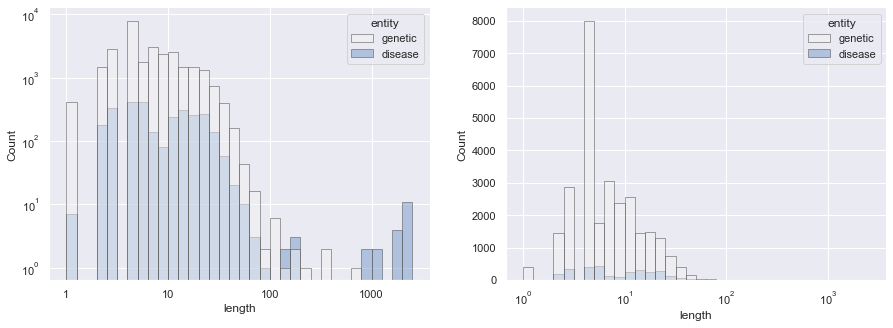

In [7]:
# visualize histogram of length of words by genetic and disease types
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.despine(f)
ax1.set_yscale('log')
sns.histplot(
    ax = ax1,
    data = prefilter_word_stats, 
    x='length', hue='entity',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=0.1,
    log_scale=True
)
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_xticks([1, 10, 100, 1000])

sns.histplot(
    ax = ax2,
    data = prefilter_word_stats, 
    x='length', hue='entity',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=0.1,
    log_scale=True
)
f.savefig('figures/word_length_hist.png')

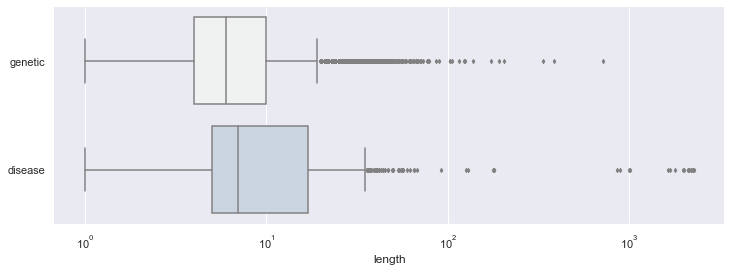

In [8]:
# visualize boxplot of length of words by genetic and disease type (same information as shown above)
f, ax = plt.subplots(figsize=(12, 4))
ax.set_xscale("log")
sns.boxplot(x="length", y="entity", data=prefilter_word_stats, 
            fliersize=3,
            palette=sns.light_palette("#79C", n_colors=4))
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.savefig('figures/word_length_boxplot.png')

In [9]:
# explore what are some of the data entries that are longer than 125 characters
long_words = prefilter_word_stats[prefilter_word_stats['length'] >= 125][['word', 'length']]
print(long_words.head(10), f'\n\nNumber of words longer than 125 characters: {len(long_words)}')

                                                   word length
1393  activityhdac 1rpd3 deacetylasenucleusznhdac 2r...    191
1398  assembly complexcbp-associated factorcreb-bind...    333
1597  elsevier ltdchemical structures of hdac inhibi...   1635
2538  elsevier ltdepigenetic mechanisms comprise all...   2102
2857  baf60bswp61 arp7bap55baf53rsc11 arp7bap55baf53...    174
3754  ] zmcenp-c [ 57 58 ] cbf5 [ 87 ] nop60bs [ 88 ...    138
3755  cpel2 [ 60 ] passenger proteinscenp-f [ 92 ] c...    383
4077  remodeling factorchromatin-accessibility compl...    203
5443  gene in fpd / aml . synonyms for runt-related ...    179
8974  gene . open box and line represent exon and in...    886 

Number of words longer than 125 characters: 31


- Remove words which are longer than 125 (somewhat arbitrary) characters long because these are probably erroneously selected

In [10]:
# remove words which are longer than 150 characters
filtered_combined_data = {}
for article, [entities, origin] in raw_combined_data.items():
    filtered_combined_data[article] = [entities[entities['word'].str.len() < 125], origin]

In [11]:
# total number of words
nWords = 0
for article, [entities, origin] in filtered_combined_data.items():
    nWords += entities['word'].size
print(f'total number of words: {nWords}')

total number of words: 30977


In [12]:
# calculate the frequency of each word
genetic_words = np.array([])
unnormed_genetic_words = np.array([])
disease_words = np.array([])
unnormed_disease_words = np.array([])
word_lengths = np.array([])
for article, [entities, origin] in filtered_combined_data.items():
    # aggregate every genetic words instance
    genetic_words = np.append(genetic_words, entities[entities['entity'] == 'genetic']['normalized word'].astype('string').to_numpy())
    unnormed_genetic_words = np.append(unnormed_genetic_words, entities[entities['entity'] == 'genetic']['word'].astype('string').to_numpy())
    # aggregate every disease words instance
    disease_words = np.append(disease_words, entities[entities['entity'] == 'disease']['normalized word'].astype('string').to_numpy())
    unnormed_disease_words = np.append(unnormed_disease_words, entities[entities['entity'] == 'disease']['word'].astype('string').to_numpy())
    # record the lengths of every word
    word_lengths = np.append(word_lengths, entities['normalized word'].str.len())

# calculate frequency of each distinct word
uniq_genetic_words, genetic_counts = np.unique(genetic_words, return_counts=True)
uniq_unnormed_genetic_words = np.unique(unnormed_genetic_words)
uniq_disease_words, disease_counts = np.unique(disease_words, return_counts=True)
uniq_unnormed_disease_words = np.unique(unnormed_disease_words)

# sort by frequency
genetic_by_counts = {word: count for count, word in sorted(zip(genetic_counts, uniq_genetic_words), reverse=True)}
genetic_by_counts = pd.DataFrame({
    'word': genetic_by_counts.keys(),
    'count': genetic_by_counts.values()
})
disease_by_counts = {word: count for count, word in sorted(zip(disease_counts, uniq_disease_words), reverse=True)}
disease_by_counts = pd.DataFrame({
    'word': disease_by_counts.keys(),
    'count': disease_by_counts.values()
})

In [14]:
genetic_by_counts.to_csv('NER_entities_by_count/genetic_entities_by_count.csv')
disease_by_counts.to_csv('NER_entities_by_count/disease_entities_by_count.csv')

In [13]:
# how many entities were reduced as a result of normalization
print(pd.DataFrame({
    'Normed v. Regular': ['regular', 'normalized', 'difference'],
    'Genetic': [len(uniq_unnormed_genetic_words), len(uniq_genetic_words), 
                     len(uniq_unnormed_genetic_words) - len(uniq_genetic_words)],
    'Disease': [len(uniq_unnormed_disease_words), len(uniq_disease_words), 
                     len(uniq_unnormed_disease_words) - len(uniq_disease_words)],
}).set_index('Normed v. Regular'))

                   Genetic  Disease
Normed v. Regular                  
regular              10149     1064
normalized            9558      972
difference             591       92


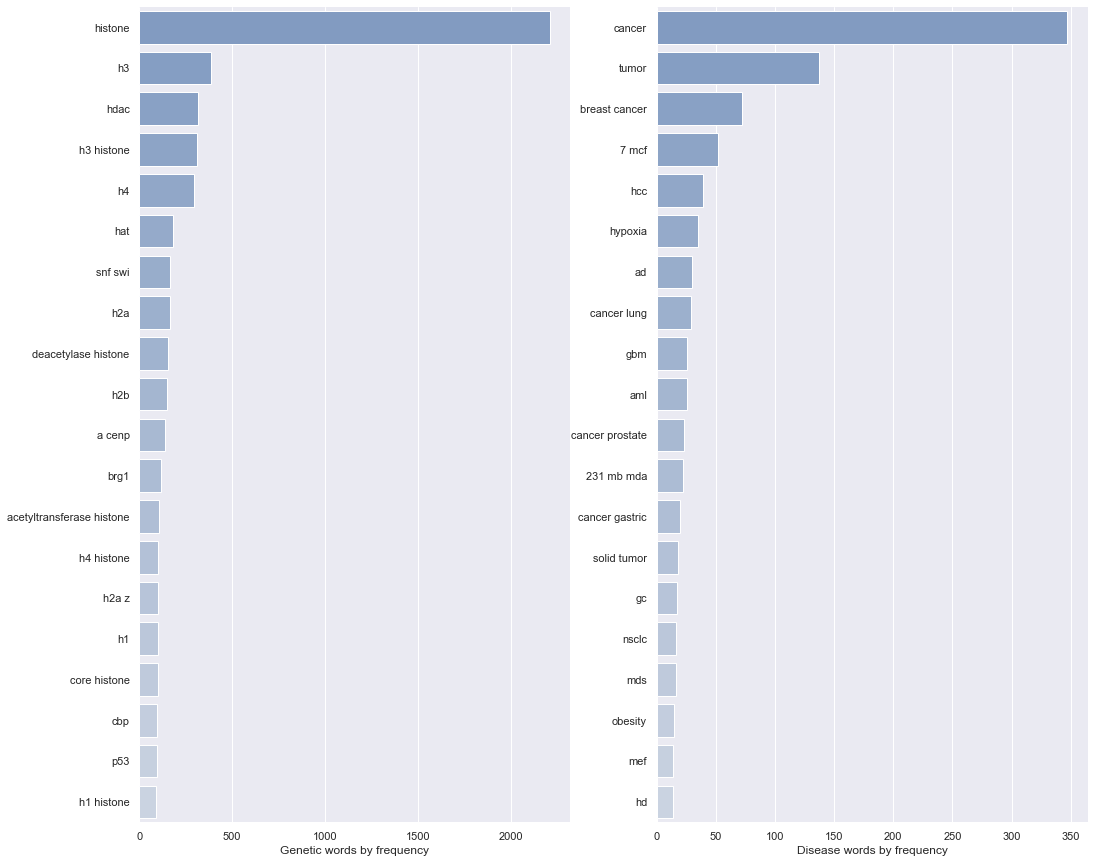

In [14]:
# barplot showing the most frequent (normalized) words for genetics and disease separately
sns.set_theme(style="darkgrid")

f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(17, 15))
sns.set_color_codes("pastel")
sns.barplot(ax =ax1, y='word', x='count', data=genetic_by_counts.head(20),
            label="Total", palette=sns.light_palette("#79C", n_colors=30, reverse=True))
sns.set_color_codes("pastel")
sns.barplot(ax =ax2, y='word', x='count', data=disease_by_counts.head(20),
            label="Total", palette=sns.light_palette("#79C", n_colors=30, reverse=True))
ax1.set(ylabel="", xlabel="Genetic words by frequency")
ax2.set(ylabel="", xlabel="Disease words by frequency")
sns.despine(left=True, bottom=True)
f.savefig('figures/most_common_words.png')

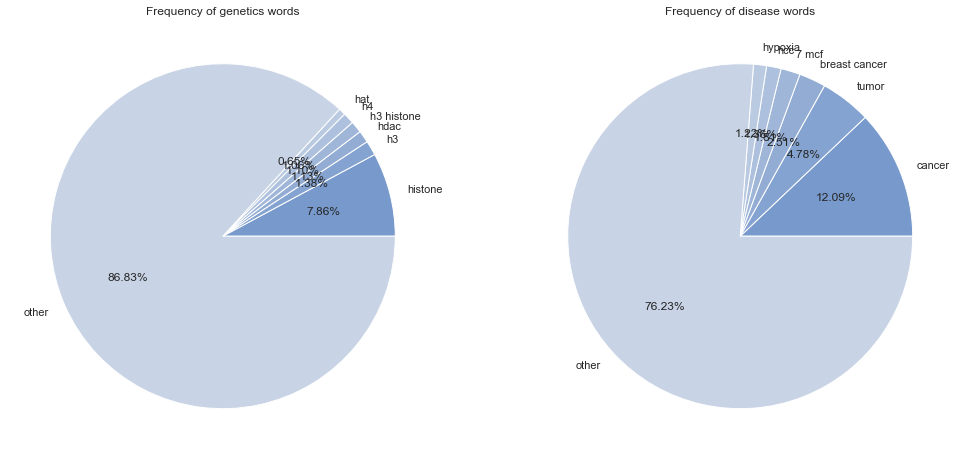

In [24]:
# create pie chart showing frequency of words (same information as above)
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))
nPieces = 7 # any more than this and the pie chart becomes illegible

# genetic words
pie_genetic_words = genetic_by_counts.head(nPieces-1)['word']
pie_genetic_words = pd.concat([
    pie_genetic_words,
    pd.Series(['other'])
])
pie_genetic_counts = genetic_by_counts.head(nPieces-1)['count']
pie_genetic_counts = pd.concat([
    pie_genetic_counts,
    pd.Series(genetic_by_counts[nPieces-1:]['count'].sum())
])

# disease words
pie_disease_words = disease_by_counts.head(nPieces-1)['word']
pie_disease_words = pd.concat([
    pie_disease_words,
    pd.Series(['other'])
])
pie_disease_counts = disease_by_counts.head(nPieces-1)['count']
pie_disease_counts = pd.concat([
    pie_disease_counts,
    pd.Series(disease_by_counts[nPieces-1:]['count'].sum())
])

# plotting data on chart
ax1.pie(pie_genetic_counts, 
        labels=pie_genetic_words, 
        colors=sns.light_palette("#79C", n_colors=10, reverse=True), 
        autopct='%0.2f%%')
ax1.set_title('Frequency of genetics words')
ax2.pie(pie_disease_counts, 
        labels=pie_disease_words, 
        colors=sns.light_palette("#79C", n_colors=10, reverse=True), 
        autopct='%0.2f%%')
ax2.set_title('Frequency of disease words')
f.savefig('figures/mos_common_words_pie_chart.png')

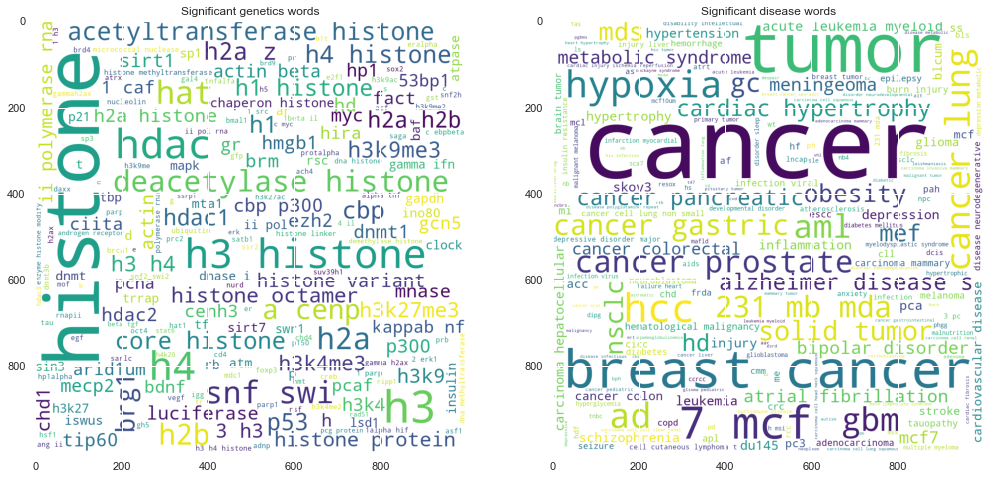

In [25]:
# word cloud showing most frequent words (same information as above)
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))

genetic_by_counts_dict = dict(zip(genetic_by_counts['word'], genetic_by_counts['count']))
disease_by_counts_dict = dict(zip(disease_by_counts['word'], disease_by_counts['count']))

genetic_wc = WordCloud(background_color ='white',width=1000,height=1000).generate_from_frequencies(genetic_by_counts_dict)
disease_wc = WordCloud(background_color ='white',width=1000,height=1000).generate_from_frequencies(disease_by_counts_dict)

ax1.imshow(genetic_wc)
ax1.set_title('Significant genetics words')
ax2.imshow(disease_wc)
ax2.set_title('Significant disease words')
f.savefig('figures/wordcloud.png')

- Explore how many articles contain "disease" keywords
- What proportion of all entities are "disease" entities?

In [36]:
# explore how many articles contain "disease" keywords
disease_stats = pd.DataFrame(columns = [
    'num entities',
    'has disease entity',
    'proportion of disease entities',
    'origin'
])
# calculate the above quantities for every article in the data
for article, [entities, origin] in filtered_combined_data.items():
    entity_is_disease = entities['entity'] == 'disease'
    disease_stats = pd.concat([disease_stats, pd.DataFrame({
        'num entities': [entities['entity'].size],
        'has disease entity': [entity_is_disease.any() * 1],
        'proportion of disease entities': [entity_is_disease.mean()],
        'origin': [origin]
    })], ignore_index=True)
    disease_stats.reset_index()

In [37]:
# what proportion of articles had disease entities
print(f'Proportion of articles containing at least one disease entity: {disease_stats["has disease entity"].mean():.5f}')

# what is the total proportion of disease entities among all entities
disease_proportion = sum(disease_stats['proportion of disease entities'] * disease_stats['num entities']) / nWords
print(f'Total proportion of disease entities among all entities: {disease_proportion:.5f}')

Proportion of articles containing at least one disease entity: 0.35170
Total proportion of disease entities among all entities: 0.09262


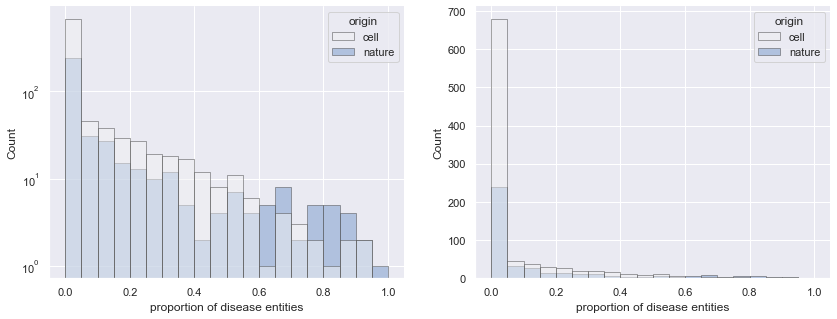

In [63]:
# visualize histogram of proportion of disease entities per article
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.despine(f)

sns.histplot(
    ax = ax1,
    data = disease_stats, 
    x='proportion of disease entities', hue='origin',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=0.05
)
ax1.set_yscale('log')

sns.histplot(
    ax = ax2,
    data = disease_stats, 
    x='proportion of disease entities', hue='origin',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=0.05
)
f.savefig('figures/proportion_of_disease_entities_per_article.png')

- Which articles with the most genetic/disease entities

In [107]:
# explore which articles have the most entities overall
entity_density_stats = pd.DataFrame(columns = [
    'doi',
    'nEntities',
    'nGenetic',
    'nDisease',
    'text',
    'origin'
])
# calculate the above quantities for every article in the data
for article, [entities, origin] in filtered_combined_data.items():
    num_entities = entities['entity'].size
    num_disease_entities = (entities['entity'] == 'disease').sum()
    expo_text_src = cell_data if origin == 'cell' else nature_data
    expo_text = expo_text_src[article][0][:80].replace('Elsevier ', '').replace('Academic Press', '')
    entity_density_stats = pd.concat([entity_density_stats, pd.DataFrame({
        'doi': [article],
        'nEntities': [num_entities],
        'nGenetic': [num_entities - num_disease_entities],
        'nDisease': [num_disease_entities],
        'text': expo_text,
        'origin': origin
    })], ignore_index=True)
    entity_density_stats.reset_index()
# sort by number of genetic and disease entities
articles_by_genetic = entity_density_stats.sort_values('nGenetic', ascending=False)
articles_by_disease = entity_density_stats.sort_values('nDisease', ascending=False)

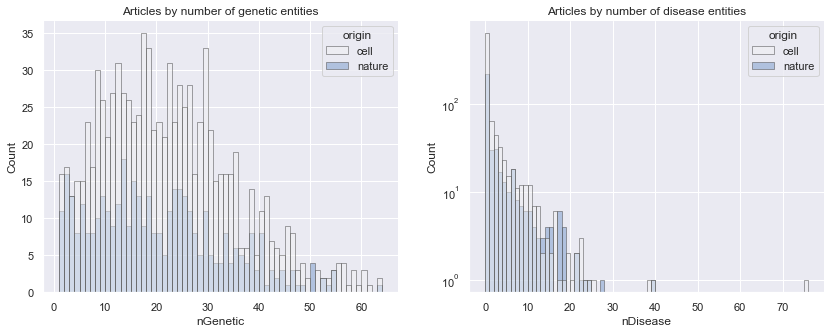

In [130]:
# visualize histogram of proportion of disease entities per article
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.despine(f)

sns.histplot(
    ax = ax1,
    data = entity_density_stats, 
    x='nGenetic', hue='origin',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=1
)
ax1.set_title('Articles by number of genetic entities')

sns.histplot(
    ax = ax2,
    data = entity_density_stats, 
    x='nDisease', hue='origin',
    palette=sns.light_palette("#79C", n_colors=2),
    edgecolor='.3',
    linewidth=0.5,
    binwidth=1
)
ax2.set_yscale('log')
ax2.set_title('Articles by number of disease entities')
f.savefig('figures/number_of_entities_by_journal.png')

In [118]:
# show articles with most genetic entities
pd.options.display.width = 120
pd.options.display.max_colwidth = 70
print(articles_by_genetic.head(30)[['nEntities', 'nGenetic', 'text', 'origin']])

     nEntities nGenetic                                                                   text  origin
586         66       64  LtdHistone Variants in Neurogenesis.DOT1 binds to nucleosomes toge...    cell
215         65       64  Inc.Mitochondrial ROS drive initiation of the inflammatory cascade...    cell
983         63       63  Both the general transcription factor complex, TFIID, and a multic...  nature
10          61       61  LtdSchematic presentation of the DDR proteins MDC1, NBS1, ATM and ...    cell
887         68       60  Inc.Pharmacological inhibitors of HDAC can induce cardiac protecti...    cell
559         60       60  Ireland LtdHistone tail modifications regulate DNA accessibility. ...    cell
734         60       60     Abbreviations used: CAF-1, chromatin assembly factor-1; chCAF-1p48    cell
679         59       59  GmbHInfluence of tobacco smoke oxidants on MAPK signalling (based ...    cell
160         58       58  LtdModel of the transcriptional regulation of SA

In [119]:
# show articles with most disease entities
pd.options.display.width = 120
pd.options.display.max_colwidth = 70
print(articles_by_disease.head(30)[['nEntities', 'nDisease', 'text', 'origin']])

     nEntities nDisease                                                                   text  origin
753         81       76  B.V.Forest plot showing the hazard ratio and 95% confidence interv...    cell
478         57       39  KAT6A and KAT6B belong to the MYST family of lysine acetyltransfer...    cell
1310        43       39  Cancer is the leading cause of disease-related death worldwide in ...  nature
244         53       38  B.V.Evidence for epigenetic regulation of genes previously identif...    cell
1037        28       27  Obesity is a public health crisis, contributing to morbidity and m...  nature
520         31       25  Inc.Representative SSCP and DNA sequencing of  from tumors (lane T...    cell
391         46       24  B.V.Pathways of JMJD3 in cancer. Cellular senescence is triggered ...    cell
1266        27       24  Glioblastoma (GBM), the grade IV astrocytoma as per World Health O...  nature
1126        37       23  Myelodysplastic syndromes (MDS) are a group of c